# Simulating a point mass door attached to spring damper system
In this notebook we attempt to simulate the following equation numerically:
$$m\ddot{x} + \gamma \dot{x} + kx = -F_{ext}$$

For now we consider the external force to be 0 (Solving the homogeneos form). A source term can be easily added.

In [3]:
using DifferentialEquations
using LinearAlgebra
using Plots

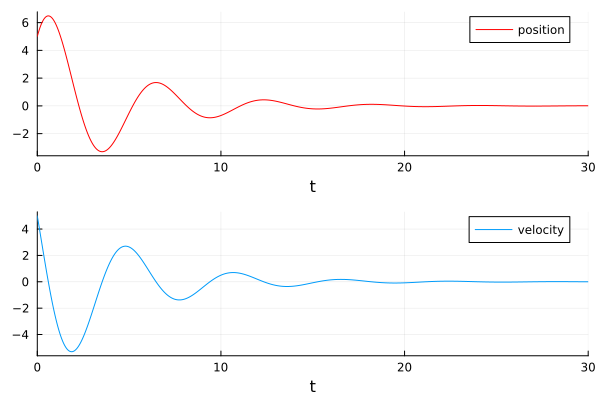

In [36]:
k = 60
c = 23
m = 50
tspan = (0.0,30.0)      

function spring_damper1D!(ddu, du, u, p, t)                                        
    ddu[1] = -1/m * (k*u[1] + c*du[1])                                                               
end                                                                              
                                                                            
function init_equation(v0=0.0, x0=3.0)                                                               
    du0 = [v0]                                                                  
    u0 = [x0]                                                                   
    prob = SecondOrderODEProblem(spring_damper1D!,du0,u0,tspan)                    
    sol = solve(prob)                                                            
end

sol = init_equation(5.0, 5.0)

p1 = plot(sol, vars=2, label="position", ylabel="m", color=:red)
p2 = plot(sol, vars=1, label="velocity", ylabel="m/s")


plot(p1, p2, layout=(2, 1))